# Importing libraries

In [1]:
import os
import chemprop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA

C:\Users\prate\anaconda3\envs\my-rdkit-env1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_parity(y_true, y_pred, y_pred_unc=None):
    
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1)
    
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    
    ax = plt.gca()
    ax.set_aspect('equal')
    
    at = AnchoredText(
    f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    plt.xlabel('True')
    plt.ylabel('Chemprop Predicted')
    
    plt.show()
    
    return

In [3]:
import pandas as pd
import numpy as np

X_train = pd.read_csv('test_checkpoints_reg/fold_0/train_full.csv')
X_train = X_train.drop(['PCE_max(%)'], axis = 1)
X_train = X_train.drop([191])  # Mordred is  not able to calculate descriptors for acceptor at this posotion
X_train

X_val=pd.read_csv('test_checkpoints_reg/fold_0/val_full.csv')
X_val = X_val.drop(['PCE_max(%)'], axis = 1)
X_val

X_test=pd.read_csv('test_checkpoints_reg/fold_0/test_full.csv')
X_test = X_test.drop(['PCE_max(%)'], axis = 1)
X_test

,p(SMILES),n(SMILES)
0,CC1=CC(CCCCCC)=C(C)S1,O=C1N(CCCCCC)C(C2=C1N=CC(C#CC3=CC=C(C#CC(C=C4)...
1,O=C(OCC(CC)CCCC)C1=C(F)C2=C(C)SC(C3=CC4=C(C(C5...,O=C(N(C(CCCCC)CCCCC)C1=O)C2=CC3=C(C4=C5C=CC1C4...
2,CC1=CC(CCCCCC)=C(C)S1,CCCCCCC(C=C1)=CC=C1C2(C3=CC=C(CCCCCC)C=C3)C4=C...
3,CC1=CC(C(S1)=C2C3=CC(Cl)=C(CC(CC)CCCC)S3)=C(C4...,CCCCCCC(C=C1)=CC=C1C2(C3=CC=C(CCCCCC)C=C3)C4=C...
4,CC1=CC2=C(S1)C(C3=CC=C(SCCCCCCCC)S3)=C4C(OC(C5...,O=C(/C(S1)=C/C(C2=NSN=C32)=CC=C3C(S4)=CC5=C4C6...
...,...,...
127,O=C(OCC(CC)CCCC)C1=C(F)C2=C(C)SC(C3=CC4=C(C(C5...,CCCCCCC(C=C1)=CC=C1C(C2=C3SC(C4=C(CC(CC)CCCC)C...
128,CC(SC1=C2C3=CC=C(CC(CC)CCCC)S3)=CC1=C(C4=CC=C(...,O=C1C2=C(C(/C1=C/C3=CC4=C(C5=CC6=C(C=C5C4(C7=C...
129,CC1=CC(CCCCCC)=C(C)S1,O=C1C(C2=C(C3=CC=CS3)N1CCCCCCCCCCCC)=C(C4=CC=C...
130,CC(SC1=C2C3=CC=C(CC(CC)CCCC)S3)=CC1=C(C4=CC=C(...,CCCCCCC(C=C1)=CC=C1C(C2=CC=C(CCCCCC)C=C2)(O3)C...


In [4]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from tqdm import tqdm

def fp_list_from_smiles_list(smiles_list,n_bits=512):                        # This code snippet is taken from http://practicalcheminformatics.blogspot.com/2019/11/visualizing-chemical-space.html
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=512):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

donor_morgan_fp = fp_list_from_smiles_list(X_train['p(SMILES)'])
donor_morgan_fp_train = pd.DataFrame(donor_morgan_fp)
donor_morgan_fp_train = donor_morgan_fp_train.add_prefix('Donor_')

acceptor_morgan_fp = fp_list_from_smiles_list(X_train['n(SMILES)'])
acceptor_morgan_fp_train = pd.DataFrame(acceptor_morgan_fp)
acceptor_morgan_fp_train = acceptor_morgan_fp_train.add_prefix('Acceptor_')

frames_train = [donor_morgan_fp_train, acceptor_morgan_fp_train]
X_train_morgan = pd.concat(frames_train, axis =1)



donor_morgan_fp = fp_list_from_smiles_list(X_val['p(SMILES)'])
donor_morgan_fp_val = pd.DataFrame(donor_morgan_fp)
donor_morgan_fp_val = donor_morgan_fp_val.add_prefix('Donor_')

acceptor_morgan_fp = fp_list_from_smiles_list(X_val['n(SMILES)'])
acceptor_morgan_fp_val = pd.DataFrame(acceptor_morgan_fp)
acceptor_morgan_fp_val = acceptor_morgan_fp_val.add_prefix('Acceptor_')

frames_val = [donor_morgan_fp_val, acceptor_morgan_fp_val]
X_val_morgan = pd.concat(frames_val, axis =1)




donor_morgan_fp = fp_list_from_smiles_list(X_test['p(SMILES)'])
donor_morgan_fp_test = pd.DataFrame(donor_morgan_fp)
donor_morgan_fp_test = donor_morgan_fp_test.add_prefix('Donor_')

acceptor_morgan_fp = fp_list_from_smiles_list(X_test['n(SMILES)'])
acceptor_morgan_fp_test = pd.DataFrame(acceptor_morgan_fp)
acceptor_morgan_fp_test = acceptor_morgan_fp_test.add_prefix('Acceptor_')

frames_test = [donor_morgan_fp_test, acceptor_morgan_fp_test]
X_test_morgan = pd.concat(frames_test, axis =1)

X_train_morgan.to_csv('X_train_morgan.csv')
X_val_morgan.to_csv('X_val_morgan.csv')
X_test_morgan.to_csv('X_test_morgan.csv')


  0%|                                                                                         | 0/1053 [00:00<?, ?it/s]C:\Users\prate\anaconda3\envs\my-rdkit-env1\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
100%|███████████████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 457.48it/s]


In [5]:
X_train_morgan

,Donor_0,Donor_1,Donor_2,Donor_3,Donor_4,Donor_5,Donor_6,Donor_7,Donor_8,Donor_9,...,Acceptor_502,Acceptor_503,Acceptor_504,Acceptor_505,Acceptor_506,Acceptor_507,Acceptor_508,Acceptor_509,Acceptor_510,Acceptor_511
0,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1049,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1050,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1051,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_val_morgan

,Donor_0,Donor_1,Donor_2,Donor_3,Donor_4,Donor_5,Donor_6,Donor_7,Donor_8,Donor_9,...,Acceptor_502,Acceptor_503,Acceptor_504,Acceptor_505,Acceptor_506,Acceptor_507,Acceptor_508,Acceptor_509,Acceptor_510,Acceptor_511
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
128,0,1,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
129,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
130,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X_test_morgan

,Donor_0,Donor_1,Donor_2,Donor_3,Donor_4,Donor_5,Donor_6,Donor_7,Donor_8,Donor_9,...,Acceptor_502,Acceptor_503,Acceptor_504,Acceptor_505,Acceptor_506,Acceptor_507,Acceptor_508,Acceptor_509,Acceptor_510,Acceptor_511
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
128,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
130,0,1,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# X_train_morgan = pd.read_csv('X_train_morgan.csv')
# X_val_morgan = pd.read_csv('X_val_morgan.csv')
# X_test_morgan = pd.read_csv('X_test_morgan.csv')

In [9]:
all_data = pd.concat([X_train_morgan,X_val_morgan,X_test_morgan])

In [10]:
all_data=all_data.select_dtypes(exclude=object)
all_data= all_data.replace([np.inf, -np.inf], np.nan)
all_data=all_data.dropna()
all_data= all_data.replace(np.nan,0)
print('Features with zero standard deviation :',len(all_data.std()[all_data.std() == 0]))
all_data=all_data.drop(all_data.std()[all_data.std() == 0].index.values, axis=1)   #To remove columns with std deviation equals to zero

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
a=sel.fit_transform(all_data)
sel.get_support()
features = all_data.columns[sel.get_support()]
print('Features selected by using variance threshold of 0.8 :',len(features))
f = features


X_train_morgan = X_train_morgan[f]
X_val_morgan = X_val_morgan[f]
X_test_morgan = X_test_morgan[f]

Features with zero standard deviation : 86
Features selected by using variance threshold of 0.8 : 126


In [11]:
y_train=pd.read_csv('test_checkpoints_reg/fold_0/train_full.csv')
y_train = y_train.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)
y_train=y_train.drop([191])  # Mordred is  not able to calculate descriptors for acceptor at this posotion

y_val=pd.read_csv('test_checkpoints_reg/fold_0/val_full.csv')
y_val = y_val.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)

y_test=pd.read_csv('test_checkpoints_reg/fold_0/test_full.csv')
y_test = y_test.drop(['p(SMILES)', 'n(SMILES)'], axis = 1)

In [12]:
# Defining Metrics
def R2Score(X,Y):
    r2=metrics.r2_score(X,Y)
    return r2
def PearsonCoefficient(X, Y):
    corr, _ = pearsonr(X,Y)
    return corr
def MSE(X,Y):
    mse=mean_squared_error(X,Y)
    return mse
def RMSE(X,Y):
    rmse=np.sqrt(mean_squared_error(X,Y))
    return rmse
def MAPE(X,Y):
    mape=np.average(abs(np.array(X)-np.array(Y))/np.array(Y))*100
    return mape


from sklearn.metrics import r2_score
import sklearn.metrics as metrics
from scipy.stats.stats import pearsonr

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1],
}

In [ ]:
X_train_morgan

In [ ]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
tune_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)
tune_xgb.fit(X_train_morgan, y_train)
# print clf.best_score_
tune_xgb.best_params_

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
 
 # create regressor object
regressor = XGBRegressor(random_state = 42)
 
# fit the regressor with x and y data
regressor.fit(X_train_morgan, y_train)  

pred = regressor.predict(X_test_morgan)

y_test = y_test.to_numpy().ravel()

# Or use the saved model

In [15]:
import pickle
with open('./Models/morgan_xgboost.pkl', 'rb') as f:
    regressor = pickle.load(f)
    
# fit the regressor with x and y data
regressor.fit(X_train_morgan, y_train) 

pred = regressor.predict(X_test_morgan)
y_test = y_test.to_numpy().ravel()

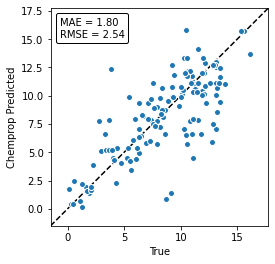

In [16]:
plot_parity(y_test, pred)

In [17]:
PearsonCoefficient(y_test, pred)

0.7736639614324669

In [18]:
R2Score(y_test, pred)

0.5585606242882257

In [19]:
import numpy as np
RMSE(y_test, pred)

2.5376187339139844

In [20]:
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)

layout0= go.Layout(title= "PCE", hovermode= 'closest',
                   font = dict(family='Times New Roman',size=28),
                   xaxis= dict(title= 'Reported PCE (%)',zeroline= False, gridwidth= 2, dtick=2),
                   yaxis= dict(title= 'Predicted PCE (%)',zeroline= False, gridwidth= 2),#range=[-350,3750]),
                   height=600,
                   width=800,
                   showlegend= True                 
)

fit  = np.linspace(min(y_test), max(y_test))
trace0 = go.Scatter(x = y_test, y = pred, mode = 'markers', marker= dict(size= 12, color= 'blue'),name='Test Data')
# trace1 = go.Scatter(x = test_outputs ,y = y_pred, mode = 'markers', text=test_inputs.index,marker= dict(size= 12, color= 'red'), 
#                     error_y = dict(type='data',array=y_std,visible=True),name='Testing Data')
trace2 = go.Scatter(x = fit ,y = fit, mode = 'lines', marker= dict(size= 12, color= 'black'), text = 'Fit',name='Linear Fit')

data = [trace0,trace2]
fig= go.Figure(data, layout=layout0)
iplot(fig)

# Save the model

In [ ]:
# import pickle
# with open('morgan_xgboost.pkl', 'wb') as f:
#     pickle.dump(regressor, f)